참고: 
1. DeepXDE. https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html
2. Github DeepONet 코드. https://github.com/GideonIlung/DeepONet
3. 학습 데이터 다운로드: https://yaleedu-my.sharepoint.com/personal/lu_lu_yale_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Flu%5Flu%5Fyale%5Fedu%2FDocuments%2Fdatasets%2Fdeepxde&ga=1

## Problem Description
Antiderivative operator의 학습.

아래와 같이 주어진 문제에서
$$\frac{dv(x)}{dx} = u(x), \qquad x \in [0, 1],$$
$$u(0)=0$$

다음과 같은 operator를 찾는다.
$$G: u \mapsto v$$


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [20]:
torch.set_default_dtype(torch.float32)
dtype = torch.float32

In [21]:
def convert_np_to_tensor(array):
  if isinstance(array, np.ndarray):
    # Convert NumPy array to PyTorch tensor
    tensor = torch.from_numpy(array)
    return tensor.to(torch.float32)
  else:
    return array

In [ ]:
d = np.load("deeponet_antiderivative_aligned//antiderivative_aligned_test.npz", allow_pickle=True)
u_train_np, y_train_np, guy_train_np = d["X"][0], d["X"][1], d["y"]
u_train   = convert_np_to_tensor(u_train_np)
y_train   = convert_np_to_tensor(y_train_np)
guy_train = convert_np_to_tensor(guy_train_np)

print(f'u_train shape: {u_train.shape}, type: {type(u_train)}, dtype: {u_train.dtype}')
print(f'u_train shape: {y_train.shape}, type: {type(y_train)}, dtype: {y_train.dtype}')
print(f'u_train shape: {guy_train.shape}, type: {type(guy_train)}, dtype: {guy_train.dtype}')

u_train shape: torch.Size([150, 100]), type: <class 'torch.Tensor'>, dtype: torch.float32
u_train shape: torch.Size([100, 1]), type: <class 'torch.Tensor'>, dtype: torch.float32
u_train shape: torch.Size([150, 100]), type: <class 'torch.Tensor'>, dtype: torch.float32


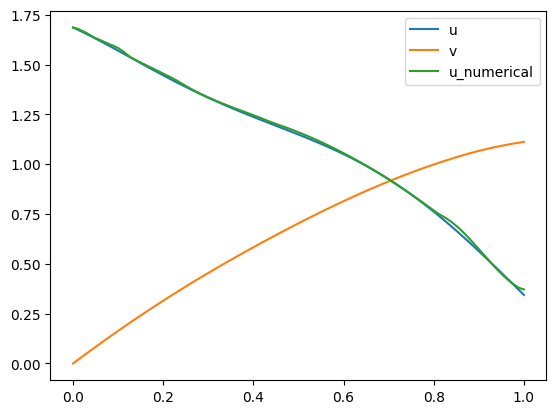

In [23]:
# Data 확인
train_idx = 11
plt.figure()
plt.plot(y_train_np, u_train_np[train_idx,:])
plt.plot(y_train_np, guy_train_np[train_idx,:])
plt.plot(y_train_np, np.gradient(guy_train_np[train_idx,:], y_train_np.squeeze()))
plt.legend(['u','v','u_numerical'])
plt.show()

In [24]:
class Datahandler(Dataset):
    """
        Handles the training Dataset 
        for the DeepONet
    """
    def __init__(self, u_branch, y_trunk, guy):
        self.u_branch = u_branch
        self.y_trunk = y_trunk
        self.guy = guy
    
    def __len__(self):
        return len(self.guy)  # Assuming x_batch and x_trunk have the same length as y

    def __getitem__(self, index):
        return self.u_branch[index,:], self.y_trunk, self.guy[index,:]

In [25]:
# 데이터 준비
dataset = Datahandler(u_train, y_train, guy_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.bias  = nn.Parameter(torch.tensor(1.0) ,requires_grad=True)
    self.branch = nn.Sequential(
      nn.Linear(100, 40), nn.ReLU(),
      nn.Linear(40, 40), nn.ReLU()
    )
    self.trunk = nn.Sequential(
      nn.Linear(1, 40), nn.ReLU(),
      nn.Linear(40, 40), nn.ReLU()
    )
    
  def forward(self, u, y):
    branch_out = self.branch(u)
    trunk_out  = self.trunk(y)
    out = branch_out@trunk_out.t() + self.bias
    return out

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight.data)
    nn.init.zeros_(m.bias)

In [27]:
model = Network()
model.apply(init_weights)

Network(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
  )
)

In [28]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_history = {'loss':[]}


In [31]:
n_epochs = 20000
for epoch in range(n_epochs):
  losses = []
  for u_batch, _, guy_batch in dataloader:
    optimizer.zero_grad()

    #forward pass through model#
    pred = model(u_batch, y_train)
    loss = loss_fn(pred, guy_batch)

    # Backward pass
    loss.backward()

    #calculate avg loss across batches#
    losses.append(loss.item())

    # Update parameters
    optimizer.step()

  avg_loss = np.mean(losses)
  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(avg_loss):.2}')

Epoch: 0, Loss: 2.9e-05
Epoch: 1000, Loss: 3.1e-05
Epoch: 2000, Loss: 0.00014
Epoch: 3000, Loss: 1e-05
Epoch: 4000, Loss: 1.3e-05
Epoch: 5000, Loss: 1.3e-05
Epoch: 6000, Loss: 1.5e-05
Epoch: 7000, Loss: 6.3e-06
Epoch: 8000, Loss: 5.8e-06
Epoch: 9000, Loss: 6.7e-06
Epoch: 10000, Loss: 4.4e-06
Epoch: 11000, Loss: 1.4e-05
Epoch: 12000, Loss: 9.7e-06
Epoch: 13000, Loss: 4.4e-06
Epoch: 14000, Loss: 4.8e-06
Epoch: 15000, Loss: 8.4e-06
Epoch: 16000, Loss: 9e-06
Epoch: 17000, Loss: 4.9e-06
Epoch: 18000, Loss: 1.8e-05
Epoch: 19000, Loss: 1.6e-05


---
# Test

In [32]:
d = np.load("deeponet_antiderivative_aligned//antiderivative_aligned_test.npz", allow_pickle=True)
u_test_np, y_test_np, guy_test_np = d["X"][0], d["X"][1], d["y"]
u_test   = convert_np_to_tensor(u_test_np)
y_test   = convert_np_to_tensor(y_test_np)
guy_test = convert_np_to_tensor(guy_test_np)

print(f'u_train shape: {u_test.shape}, type: {type(u_test)}, dtype: {u_test.dtype}')
print(f'u_train shape: {y_test.shape}, type: {type(y_test)}, dtype: {y_test.dtype}')
print(f'u_train shape: {guy_test.shape}, type: {type(guy_test)}, dtype: {guy_test.dtype}')

u_train shape: torch.Size([1000, 100]), type: <class 'torch.Tensor'>, dtype: torch.float32
u_train shape: torch.Size([100, 1]), type: <class 'torch.Tensor'>, dtype: torch.float32
u_train shape: torch.Size([1000, 100]), type: <class 'torch.Tensor'>, dtype: torch.float32


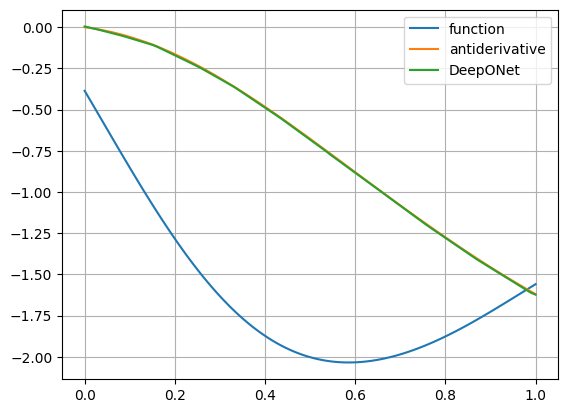

In [35]:
i = 5 #function index#
u_pred = model(u_test[i,:], y_test)
u_pred = u_pred.detach().numpy().flatten()

plt.plot(y_test_np,u_test[i,:],label='function')
plt.plot(y_test_np,guy_test[i,:],label='antiderivative')
plt.plot(y_test_np,u_pred,label='DeepONet')
plt.grid()
plt.legend(loc='best')